#  INF8225 Projet QA : HyDE vs RAG-Fusion

## Import des librairies

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
import nltk
import faiss
import torch.nn.functional as F
from torch.utils.data import Dataset

import os
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm

## Déclarations des constantes

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16

## Chargement des données

In [3]:
root_path = './'
data_path = root_path + 'data/'
questions_test = pd.read_csv(data_path + 'questions_test.csv')
questions_train = pd.read_csv(data_path+'questions_train.csv')
questions_val = pd.read_csv(data_path+'questions_val.csv')
texts = pd.read_csv(data_path + 'texts.csv')

# Colonnes utiles
passages = texts['text'].tolist()
questions_t = questions_test['question'].tolist()
questions_tr = questions_train['question'].tolist()
questions_v = questions_val['question'].tolist()

## Encoding

### Chargement de l'encodeur

In [4]:
from transformers import AutoTokenizer, AutoModel
model_name = 'BAAI/bge-base-en-v1.5'
emb_tokenizer = AutoTokenizer.from_pretrained(model_name)
emb_model = AutoModel.from_pretrained(model_name)
emb_model.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "key", "value"],
    lora_dropout=0.05,
    bias="none",
)

emb_model = get_peft_model(emb_model, lora_config)

In [6]:
emb_model.load_state_dict(torch.load("models_encoder/fine_tuned_model_weights_epoch_8.pth"))

<All keys matched successfully>

### Stockage dans FAISS

In [7]:
def encode_sequences(sequences: list, tokenizer, model, device=DEVICE, batch_size=BATCH_SIZE, training=False) -> torch.Tensor:
    model.train() if training else model.eval()
    context = torch.enable_grad() if training else torch.no_grad()

    embeddings = []
    with context:
        for i in range(0, len(sequences), batch_size):
            batch = sequences[i:i + batch_size]

            # Tokenisation des textes avant entrée du modèle
            inputs = tokenizer(
                batch, padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            # Passage dans le modèle encodeur
            output = model(**inputs).last_hidden_state

            # Pooling : moyenne des vecteurs de tous les tokens pour chaque séquence
            pooled = output.mean(dim=1)  # [batch_size, hidden_size]

            embeddings.append(pooled)

    # Concatène tous les embeddings pour obtenir un seul tensor de sortie
    return torch.cat(embeddings, dim=0)

In [8]:
passage_embed = encode_sequences(passages, emb_tokenizer, emb_model)
passage_embeddings = passage_embed.cpu().numpy()
faiss.normalize_L2(passage_embeddings) #  Normalisation des vecteurs pour l'approche similarité cosinus
d = passage_embeddings.shape[1]
index = faiss.IndexFlatIP(d)  # Index Faiss
index.add(passage_embeddings)

c:\Users\mathi\anaconda3\envs\ml_env\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [9]:
def retrieve_top_k_passages_faiss(questions: list, vector_index: faiss.IndexFlatL2, embedding_model_tokenizer, embedding_model, k: int):
    question_embeddings = encode_sequences(questions, embedding_model_tokenizer, embedding_model)
    question_embeddings = question_embeddings.cpu().numpy()
    faiss.normalize_L2(question_embeddings)
    _, top_k_indices = vector_index.search(question_embeddings, k)
    
    return top_k_indices

## HyDE

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "microsoft/biogpt"
hyde_tokenizer = AutoTokenizer.from_pretrained(model_name)
hyde_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    trust_remote_code=True
)
hyde_model = hyde_model.to(DEVICE)

### HyDE Pipeline

In [24]:
def generate_hypothetical_doc(question, model, tokenizer, max_new_tokens=128):
    prompt = f"Answer to the following question:\n{question}\n\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.9,
        eos_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else None
    )

    result = tokenizer.decode(output[0], skip_special_tokens=True).split("Answer:")[-1].strip()
    print(question)
    print(result)

    return result

In [25]:
hyde_docs = [generate_hypothetical_doc(q, hyde_model, hyde_tokenizer) for q in questions_v]
print(hyde_docs)

What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?
It is clear that the M201V variant has no effect on responsiveness to LTD4.
What is the key difference in the structure of carbapenems compared to penicillins?
Carbapenems are more potent than penicillins, with the result that the carbapenems, including imipenem and meropenem, provide the best therapeutic choice for infections caused by methicillin-resistant S.
What type of facets are there in the 8-demicubic honeycomb?
We propose that the 8-demicin honeycomb can be viewed as a three-dimensional network of hydrogen-bonded ring trimers, which are further interconnected via weak hydrogen bonds to form an intricate network of hydrogen-bonded sheets.
What is the legal status of 5F-AMB in the United States?
Although FDA's current authority was first granted for the use of 5F-AMB in the United States, its potential risk of misuse and abuse in a population with mental illness is unknown.
What is converted into estro

In [30]:
print(questions_v[0])
print(hyde_docs[0])
print(retrieve_top_k_passages_faiss([hyde_docs[0]], index, emb_tokenizer, emb_model, 5))

What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?
It is clear that the M201V variant has no effect on responsiveness to LTD4.
[[10039  3010  1908  9913  6877]]


### Evaluation

precision at 1 = 0.454
recall at 1 = 0.167 

precision at 2 = 0.401
recall at 2 = 0.29 

precision at 3 = 0.347
recall at 3 = 0.374 

precision at 4 = 0.315
recall at 4 = 0.45 

precision at 5 = 0.28
recall at 5 = 0.5 



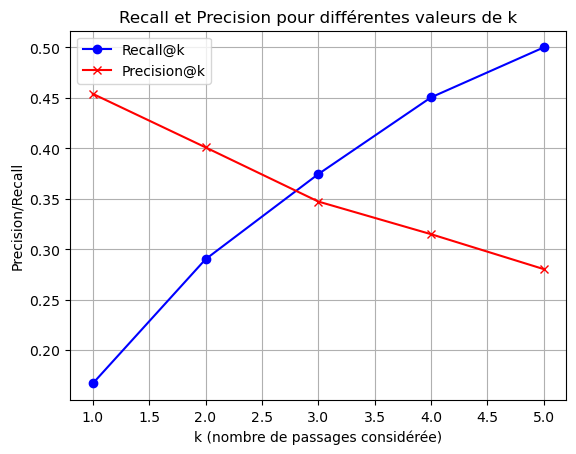

In [26]:
def compute_recall_at_k(ground_truth, predictions):
    total_recall = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):

        true_set = set(true_texts)  
        predicted_set = set(predicted_texts)

        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        recall = len(relevant_and_retrieved) / len(true_set)
        total_recall += recall
   
    average_recall = total_recall / len(ground_truth) 
    return average_recall


def compute_precision_at_k(ground_truth, predictions):
    total_precision = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):
        true_set = set(true_texts)
        predicted_set = set(predicted_texts)
        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        precision = len(relevant_and_retrieved) / len(predicted_set) 
        total_precision += precision
    
    average_precision = total_precision / len(ground_truth) 
    return average_precision

top_ground_truth = questions_val['text_ids'].apply(lambda x: [int(num) for num in x.strip('[]').split()]).to_list()

recall  = []
precision = []
for k in range(1,6) : 
    top_passages = retrieve_top_k_passages_faiss(hyde_docs, index, emb_tokenizer, emb_model, k)
    rec_at_k = compute_recall_at_k(top_ground_truth, top_passages)
    prec_at_k = compute_precision_at_k(top_ground_truth, top_passages)
    recall.append(rec_at_k)
    precision.append(prec_at_k)
    print(f'precision at {k} = {round(prec_at_k ,3) }')
    print(f'recall at {k} = {round(rec_at_k, 3)} \n')

plt.plot(range(1,6), recall, marker='o', color='b', label='Recall@k')
plt.plot(range(1,6), precision, marker='x', color='r', label='Precision@k')
plt.xlabel('k (nombre de passages considérée)')
plt.ylabel('Precision/Recall')
plt.title('Recall et Precision pour différentes valeurs de k')
plt.legend()
plt.grid(True)
plt.show()